In [1]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

IPythonConsole.ipython_useSVG = False
DrawingOptions.includeAtomNumbers = False

def get_locked_ids(mol):
    return [idx for idx, atm in enumerate(mol.atoms) if atm.is_locked]

def depict(mol):
    rd_mol = mol.asRDMol()
    
    drawer = rdMolDraw2D.MolDraw2DSVG(300, 300)
    
    # include atom indices
    opts = drawer.drawOptions()
    for i in range(rd_mol.GetNumAtoms()):
        opts.atomLabels[i] = str(i+1)
    
    # draw the molecule as SVG
    drawer.DrawMolecule(
        rd_mol
        , highlightAtoms=get_locked_ids(mol)
    )
    drawer.FinishDrawing()
    return SVG(drawer.GetDrawingText().replace('svg:',''))

def get_locked_atoms(mol):
    return [(idx, atm) for idx, atm in enumerate(mol.atoms) if atm.is_locked]

def show_mol_grid(mols):
    locked_atoms = [[y[0] for y in get_locked_atoms(x)] for x in mols]
    return MolsToGridImage(
        [x.asRDMol() for x in mols]
        , subImgSize=(250,200)
        , highlightAtomLists=locked_atoms
        , legends=[x.parent_operator for x in mols]
    )

In [2]:
from rdkit import Chem
from molpher.core import MolpherMol, MolpherAtom
from molpher.core.morphing.operators import MorphingOperator
from molpher.random_numbers import get_random_number

class AddFragment(MorphingOperator):

    def __init__(self, fragment, open_atoms_frag, oper_name):
        super(AddFragment, self).__init__()
        self._name = oper_name
        self._fragment = fragment
        self._open_atoms_frag = open_atoms_frag
        self._orig_rdkit = None
        self._open_atoms = []

    def setOriginal(self, mol):
        super(AddFragment, self).setOriginal(mol)
        if self.original:
            self._orig_rdkit = self.original.asRDMol()
            self._open_atoms = []

            for atm_rdkit, atm_molpher in zip(self._orig_rdkit.GetAtoms(), self.original.atoms):
                free_bonds = atm_rdkit.GetImplicitValence()
                if free_bonds >= 1 and not (MolpherAtom.NO_ADDITION & atm_molpher.locking_mask):
                    self._open_atoms.append(atm_rdkit.GetIdx())

    def morph(self):
        combo_mol = Chem.EditableMol(Chem.CombineMols(
            self._orig_rdkit
            , self._fragment
        ))
        atom_orig = self._open_atoms[get_random_number(0, len(self._open_atoms)-1)]
        atom_frag = len(self.original.atoms) + self._open_atoms_frag[get_random_number(0, len(self._open_atoms_frag)-1)]
        combo_mol.AddBond(atom_orig, atom_frag, order=Chem.rdchem.BondType.SINGLE)
        combo_mol = combo_mol.GetMol()
        Chem.SanitizeMol(combo_mol)

        ret = MolpherMol(other=combo_mol)
        for atm_ret, atm_orig in zip(ret.atoms, self.original.atoms):
            atm_ret.locking_mask = atm_orig.locking_mask

        return ret

    def getName(self):
        return self._name
    
captopril = MolpherMol("captopril.sdf")
frag = Chem.MolFromSmiles('c1ccccc1')
add_frag = AddFragment(frag, [1], "Add Benzene")
add_frag.setOriginal(captopril)

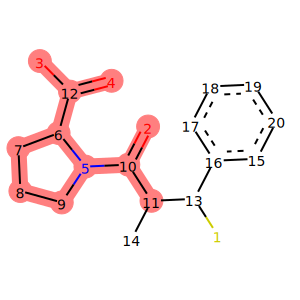

In [3]:
depict(add_frag.morph())

In [4]:
from molpher.core import ExplorationTree as ETree

captopril = MolpherMol("captopril.sdf")
enalapril = MolpherMol("O=C(O)[CH]2N(C(=O)[CH](N[CH](C(=O)OCC)CCc1ccccc1)C)CCC2")
tree = ETree.create(source=captopril, target=enalapril)
tree.morphing_operators = tree.morphing_operators + (add_frag,)

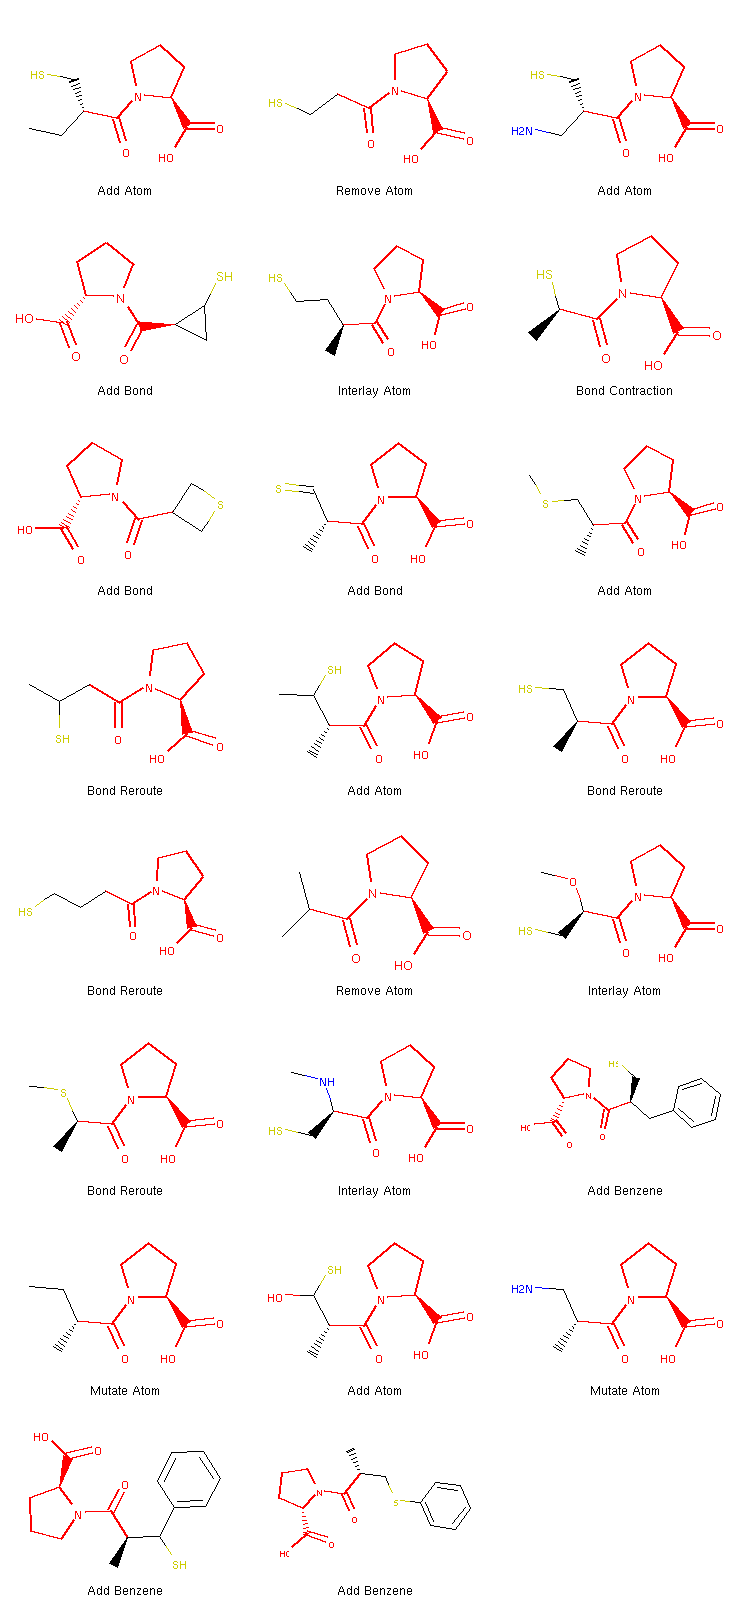

In [5]:
tree.generateMorphs()
show_mol_grid(tree.candidates)

In [6]:
class FindClosest:

    def __init__(self):
        self.closest_mol = None
        self.closest_distance = None

    def __call__(self, morph):
        if not self.closest_mol or self.closest_distance > morph.dist_to_target:
            self.closest_mol = morph
            self.closest_distance = morph.dist_to_target

closest_info = FindClosest()
while not tree.path_found:
    tree.generateMorphs()
    tree.sortMorphs()
    tree.filterMorphs()
    tree.extend()
    tree.prune()
    tree.traverse(closest_info)
    print('Generation #', tree.generation_count, sep='')
    print('Molecules in tree:', tree.mol_count)
    print(
        'Closest molecule to target: {0} (Tanimoto distance: {1})'.format(
            closest_info.closest_mol.getSMILES()
            , closest_info.closest_distance
        )
    )

Generation #1
Molecules in tree: 19
Closest molecule to target: CC(CSC1=CC=CC=C1)C(=O)N1CCCC1C(=O)O (Tanimoto distance: 0.484375)
Generation #2
Molecules in tree: 100
Closest molecule to target: CC(CCC1=CC=CC=C1)C(=O)N1CCCC1C(=O)O (Tanimoto distance: 0.3035714285714286)
Generation #3
Molecules in tree: 200
Closest molecule to target: CC(CCC1=CC=CC=C1)C(=O)N1CCCC1C(=O)O (Tanimoto distance: 0.3035714285714286)
Generation #4
Molecules in tree: 300
Closest molecule to target: CC(CCC1=CC=CC=C1)C(=O)N1CCCC1C(=O)O (Tanimoto distance: 0.3035714285714286)
Generation #5
Molecules in tree: 400
Closest molecule to target: CC(NC(O)CCC1=CC=CC=C1)C(=O)N1CCCC1C(=O)O (Tanimoto distance: 0.2586206896551724)
Generation #6
Molecules in tree: 500
Closest molecule to target: CC(CCC1=CC=CC=C1)NC(C)C(=O)N1CCCC1C(=O)O (Tanimoto distance: 0.24561403508771928)
Generation #7
Molecules in tree: 600
Closest molecule to target: CCOC(CCC1=CC=CC=C1)NC(C)C(=O)N1CCCC1C(=O)O (Tanimoto distance: 0.23333333333333328)
Gener

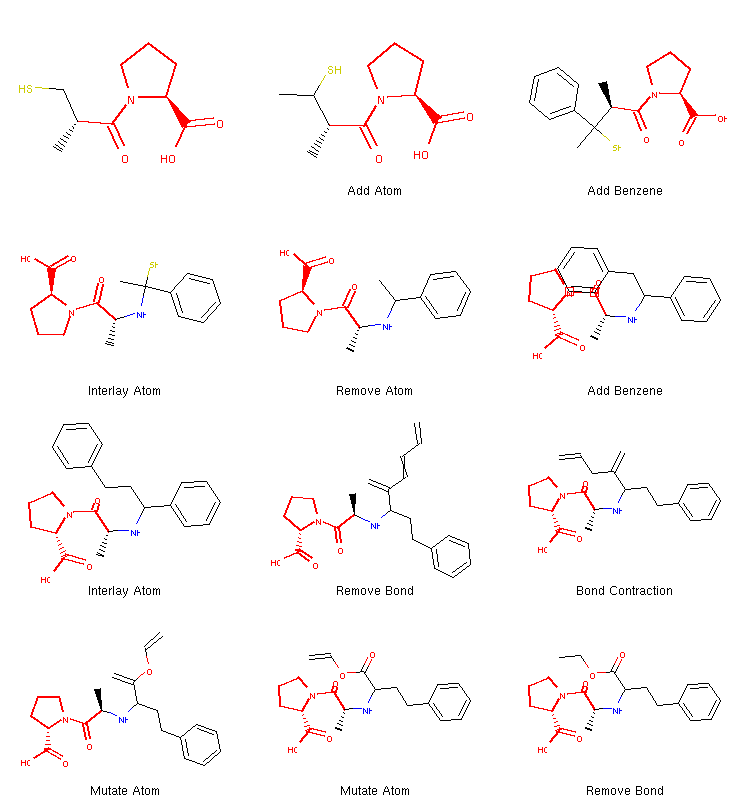

In [7]:
show_mol_grid(tree.fetchPathTo(tree.params['target']))